# CNN Skin Cancer Assignment

### By Tushar Prasad

### Run on Google Collab

Tab in collab is 2 spaces whereas tab in jupyter notebook is 4 spaces.
This notebook was downloaded from Collab, hence the scope of each loop is seperated by 2 spaces instead of 4

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## checking the shapes

train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

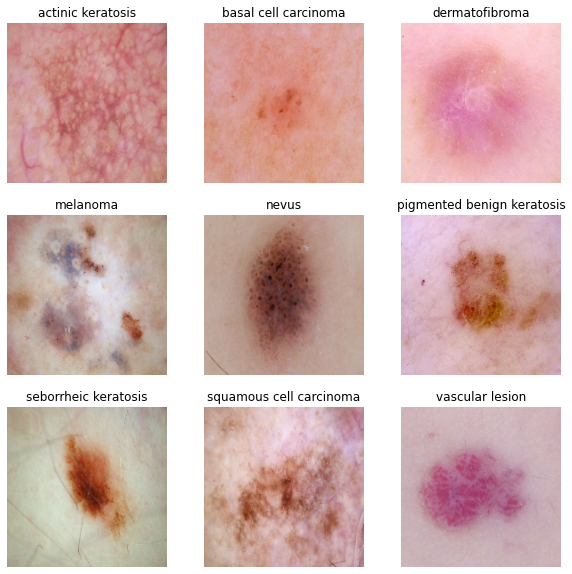

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(len(class_names)):
  flag = 0
  ax = plt.subplot(3, 3, i + 1)
  for j in range(10):
    for images, labels in train_ds.take(j):
      idx = np.where(labels[:]==i)[0]
      if len(idx)!=0:
        plt.imshow(images[idx[0]].numpy().astype("uint8"))
        plt.title(class_names[labels[idx[0]]])
        plt.axis("off")
        flag = 1
        break;
      else:
        pass
    if flag == 1:
      break;

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 422s 2s/step - loss: 1.9817 - accuracy: 0.2617 - val_loss: 1.8412 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.7017 - accuracy: 0.4029 - val_loss: 1.6022 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5449 - accuracy: 0.4475 - val_loss: 1.4672 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4633 - accuracy: 0.4777 - val_loss: 1.4768 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3579 - accuracy: 0.5246 - val_loss: 1.3678 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2959 - accuracy: 0.5357 - val_loss: 1.3425 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.1767 - accuracy: 0.5781 - val_loss: 1.3394 - val_accuracy: 0.5302
Epoch 8/20
56

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

### Visualizing training results

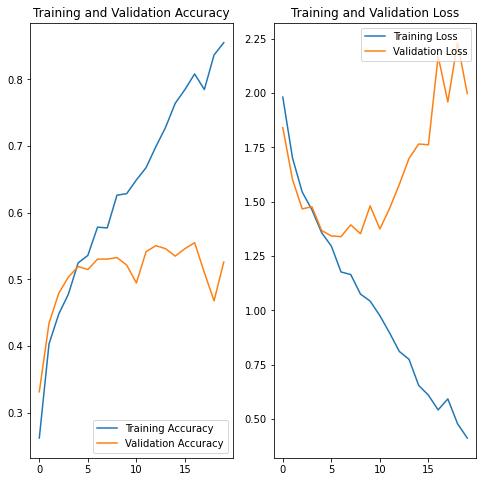

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

From visualising the training results, we have some conclusions:-

1. Training Accuracy is 85%.
2. Validation accuracy is around 52%
3. This difference between the training and validation accuracies indicate heavy overfitting.
4. The validation accuracy starts to go down after a few epochs due to overfitting

### Data Augmentation

We will do data augmentation to combat overfitting.

We will use 2 augmentation strategies here
1. We will randomly flip the images horizontally andd vertically.
2. We will randomly rotate the image by 20% clockwise and counter clock wise

In [41]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Text(0.5, 1.0, 'actinic keratosis')

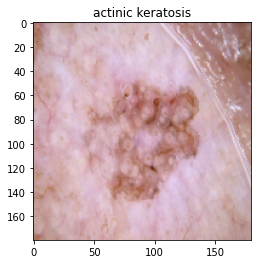

In [42]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
image, label = next(iter(train_ds))

image = image[0]
label = label[0]

plt.imshow(image.numpy().astype("uint8"))
plt.title(class_names[label])

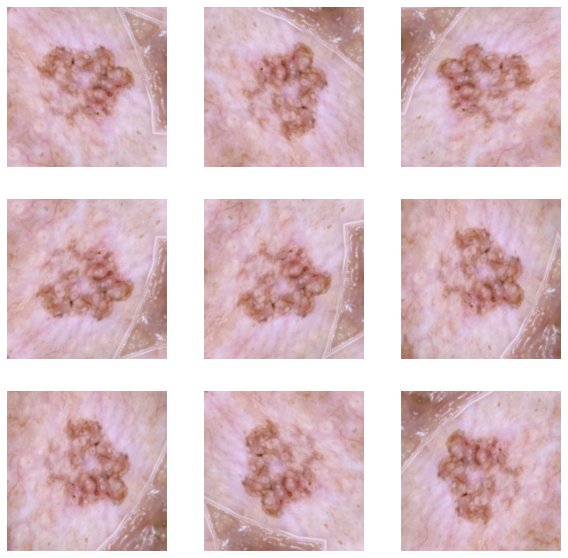

In [43]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [44]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compiling the model

In [45]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [46]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 47ms/step - loss: 2.0382 - accuracy: 0.2031 - val_loss: 2.0004 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9227 - accuracy: 0.2751 - val_loss: 1.9594 - val_accuracy: 0.2506
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.7454 - accuracy: 0.3616 - val_loss: 1.6330 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5892 - accuracy: 0.4224 - val_loss: 1.5577 - val_accuracy: 0.4430
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5078 - accuracy: 0.4598 - val_loss: 1.5151 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4817 - accuracy: 0.4710 - val_loss: 1.4361 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4566 - accuracy: 0.4766 - val_loss: 1.4567 - val_accuracy: 0.5056
Epoch 8/20
56

### Visualizing the results

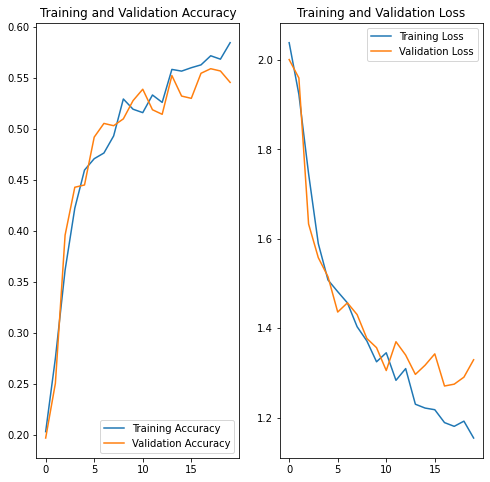

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

For this model after data augmentation, we can see that there are changes to the training accuracy from the graphs.
There is not a huge (or hardly any) difference between the training and validation accuracy.
Hence, we have fixed the overfitting problem by data augmentation. Therefore, we can say there is some improvement here even though the train accuracy has gone down. This is a more robust model.

## Class Imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [121]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
df1 = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [124]:
df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

seborrheic keratosis is the class with the least number of samples with only 77 samples out of 2239 samples (3.4%)

#### - Which classes dominate the data in terms proportionate number of samples?

pigmented benign keratosis(462), melanoma(438), basal cell carcinoma(376) and nevus(357) are the classes which dominate the distribution with each being >= 16% of the samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [86]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [90]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4FE703F810>:   0%|          | 1/500 [00:00<01:33,  5.35 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4FE6A9B110>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5044D41750>: 100%|██████████| 500/500 [00:23<00:00, 21.68 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4FE6D1C990>: 100%|██████████| 500/500 [00:23<00:00, 21.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4FE703FC10>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=966x645 at 0x7F508DDA3A50>: 100%|██████████| 500/500 [01:44<00:00,  4.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F504518C610>:   0%|          | 1/500 [00:00<01:08,  7.32 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4FE6A635D0>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5095EA5FD0>: 100%|██████████| 500/500 [00:49<00:00, 10.18 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F508DD62510>: 100%|██████████| 500/500 [00:23<00:00, 21.50 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F508DDA3650>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [91]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [127]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_90e73515-b81f-4ab5-80a3-022d6f903a23.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032642.jpg_92694655-8079-4f1f-b6b2-97dc1faf5828.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_8740783e-388f-4120-9040-c5740e06bf7d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032642.jpg_aa8c8978-6dab-4f5b-9ba2-576b628e2e41.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/derm

In [128]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [131]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [133]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

new_df = df1.append(df2)

In [134]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [138]:
new_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,dermatofibroma
1,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,dermatofibroma
2,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,dermatofibroma
3,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,dermatofibroma
4,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,dermatofibroma
...,...,...
4495,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
4496,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
4497,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
4498,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [135]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [137]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [139]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train",
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [140]:
## Your code goes here
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [141]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [142]:

## Your code goes here, use 30 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 247ms/step - loss: 1.9628 - accuracy: 0.2476 - val_loss: 1.6172 - val_accuracy: 0.3875
Epoch 2/30
169/169 [==============================] - 41s 238ms/step - loss: 1.5876 - accuracy: 0.3917 - val_loss: 1.4890 - val_accuracy: 0.4239
Epoch 3/30
169/169 [==============================] - 42s 241ms/step - loss: 1.4897 - accuracy: 0.4254 - val_loss: 1.4126 - val_accuracy: 0.4454
Epoch 4/30
169/169 [==============================] - 42s 243ms/step - loss: 1.4077 - accuracy: 0.4514 - val_loss: 1.4164 - val_accuracy: 0.4491
Epoch 5/30
169/169 [==============================] - 43s 246ms/step - loss: 1.3965 - accuracy: 0.4557 - val_loss: 1.2920 - val_accuracy: 0.4848
Epoch 6/30
169/169 [==============================] - 44s 256ms/step - loss: 1.3318 - accuracy: 0.4820 - val_loss: 1.4857 - val_accuracy: 0.4373
Epoch 7/30
169/169 [==============================] - 44s 251ms/step - loss: 1.3216 - accuracy: 0.4902 - val_loss: 1.2821 - val_ac

#### **Todo:**  Visualize the model results

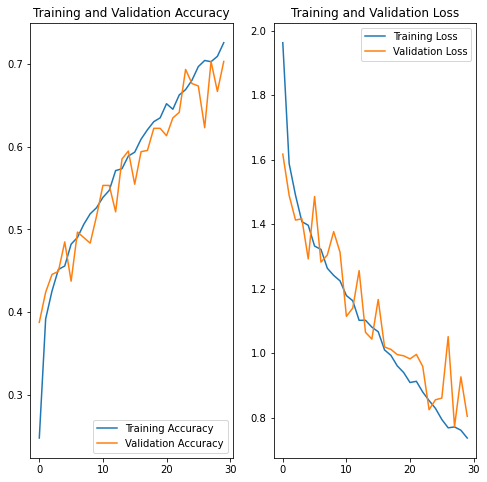

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Using class rebalance we have added 500 more images to each class. Now no class would have a low count and we have more images for training and validating as well.

Again from the graph we can see that the training accuracies and the testing accuracies across the 30 epochs are very close. Hence, there is no evidence of overfitting here. Also by using class rebalance, we have added more images which has led to better results across the training accuracies and the validation accuracies.

Our training acccuracy and our validation accuracy has increased from the mid 50% to early 70%. If we create more images and train for a longer time, these accuracies might go even higher.